In [261]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [262]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [263]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [264]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[8.03006988e-05, 1.73514436e-05, 1.73720418e-05, 2.53687574e-07,
        3.13180499e-05, 3.30103694e-06, 3.40432257e-06, 4.35280435e-06,
        6.27982226e-05, 8.25679592e-07, 1.57189703e-07, 7.95575602e-07,
        5.57476687e-09, 5.97173039e-06, 4.41594420e-06, 8.50634763e-08,
        4.05062519e-06, 5.64879811e-05, 8.03950592e-04, 1.61433141e-04,
        5.48117032e-06, 3.55433585e-08, 1.23172114e-07, 1.22647873e-06,
        8.97179234e-07, 4.73649652e-06, 2.75094663e-07, 9.71620807e-07,
        3.38484861e-05, 1.59386545e-05, 8.47436866e-07, 2.05378801e-05,
        1.07947108e-06, 5.37713106e-07, 8.40549433e-07, 1.11547983e-07,
        1.32097270e-07, 9.19753660e-08, 4.22787849e-07, 9.32677665e-07,
        2.66873594e-05, 1.95504253e-06, 1.67546261e-06, 5.41172511e-08,
        2.13772282e-07, 3.55938511e-07, 5.43410852e-06, 2.12072081e-07,
        1.38979502e-07, 6.02668280e-08, 5.42455268e-07, 7.30891315e-06,
        1.00928619e-05, 3.85450312e-06, 5.47935102e-08, 2.158825

In [265]:
model = tf.keras.applications.mobilenet.MobileNet(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [266]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [267]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [268]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [269]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [270]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 269 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [271]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
8/8 [==============================] - 8s 902ms/step - loss: 1.1700
Epoch 2/10
8/8 [==============================] - 7s 804ms/step - loss: 1.0603
Epoch 3/10
8/8 [==============================] - 7s 898ms/step - loss: 1.0317
Epoch 4/10
8/8 [==============================] - 7s 796ms/step - loss: 0.9643
Epoch 5/10
8/8 [==============================] - 7s 803ms/step - loss: 0.9227
Epoch 6/10
8/8 [==============================] - 7s 892ms/step - loss: 0.9321
Epoch 7/10
8/8 [==============================] - 7s 865ms/step - loss: 0.9860
Epoch 8/10
8/8 [==============================] - 7s 834ms/step - loss: 0.8824
Epoch 9/10
8/8 [==============================] - 7s 876ms/step - loss: 0.8604
Epoch 10/10
8/8 [==============================] - 7s 859ms/step - loss: 0.7619


KeyError: 'val_loss'

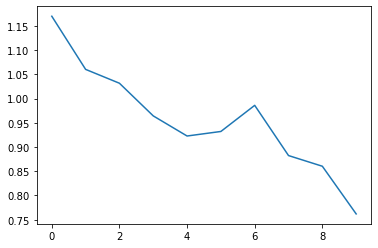

In [272]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [273]:
random_cat = random.choice(os.listdir('images/cat/'))
cat_path = os.path.join('images/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dog/'))
dog_path = os.path.join('images/dog',random_dog)
dog = load_image(dog_path)

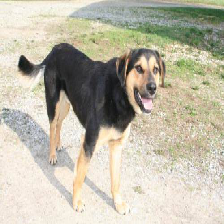

In [274]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

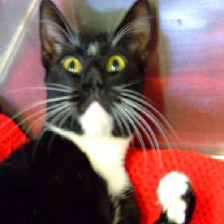

In [275]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

In [276]:
print(f'''cat:{np.round(model.predict(cat),2)}''')

cat:[[0.73 0.27]]


In [277]:
print(f'''dog:{np.round(model.predict(dog),2)}''')

dog:[[0.36 0.64]]


In [278]:
tiger_path = 'tiger.jpg'
tiger = load_image(tiger_path)

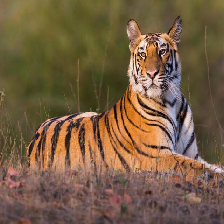

In [279]:
tf.keras.preprocessing.image.load_img(tiger_path, target_size=(224,224))

In [280]:
print(f'''tiger:{np.round(model.predict(tiger),2)}''')

tiger:[[0.54 0.46]]
